In [1]:
from math import sin, pi, exp

import numpy as np

from forecast import plot_line, plot_time_series

/Users/adam/anaconda3/envs/forecast/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/adam/anaconda3/envs/forecast/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Work below is based on Chapter 7 of [LSTM Networks with Python](https://machinelearningmastery.com/lstms-with-python/).  Some changes have been made to variable names

In [2]:
# generate damped sine wave in [0,1]
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)]

In [3]:
seq = generate_sequence(102, 20, 0.05)

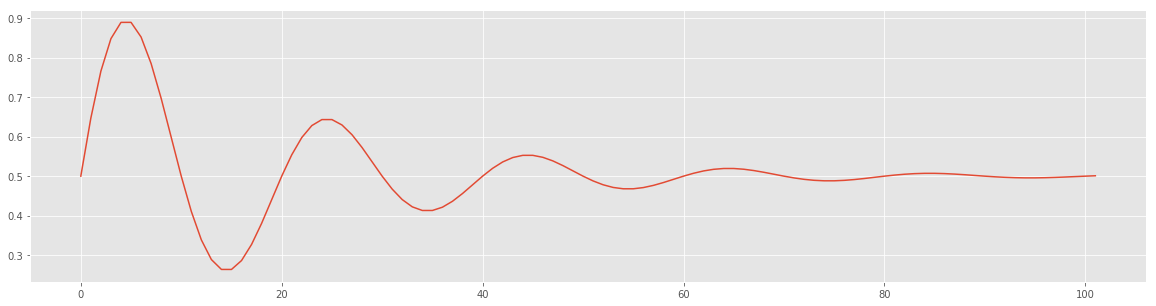

In [4]:
f = plot_line(y=seq, figsize=(20, 5))

In [5]:
# generate input and output pairs of damped sine waves
def generate_examples(length, samples, test_length):
    X, y = list(), list()
    for _ in range(samples):
        p = np.random.randint(10, 40)
        d = np.random.uniform(0.01, 0.05)
        sequence = generate_sequence(length + test_length, p, d)
        X.append(sequence[:-test_length])
        y.append(sequence[-test_length:])

    X = np.array(X).reshape(samples, length, 1)
    y = np.array(y).reshape(samples, test_length)
    return X, y

In [6]:
x, y = generate_examples(length=20, samples=5, test_length=5)

In [7]:
print(x.shape)
print(y.shape)

(5, 20, 1)
(5, 5)


[<Figure size 1440x72 with 1 Axes>,
 <Figure size 1440x72 with 1 Axes>,
 <Figure size 1440x72 with 1 Axes>,
 <Figure size 1440x72 with 1 Axes>,
 <Figure size 1440x72 with 1 Axes>]

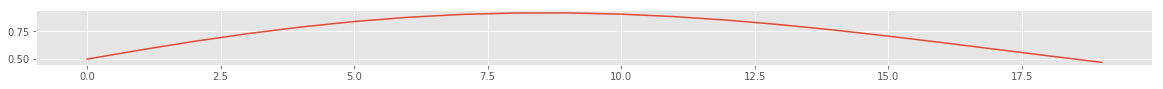

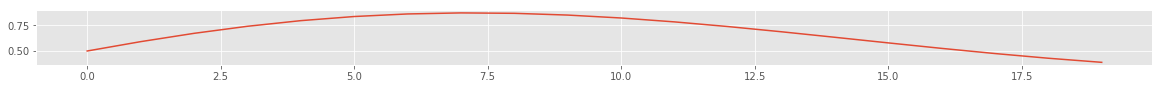

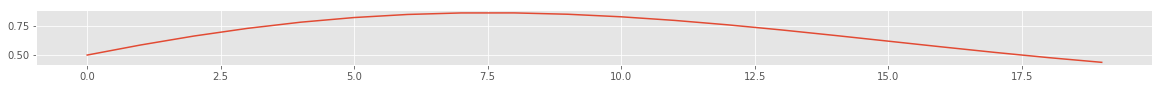

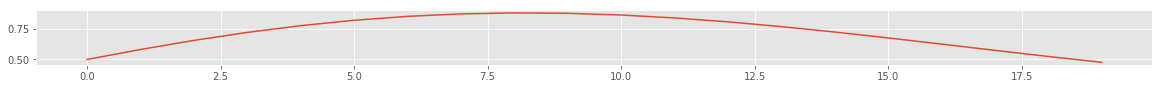

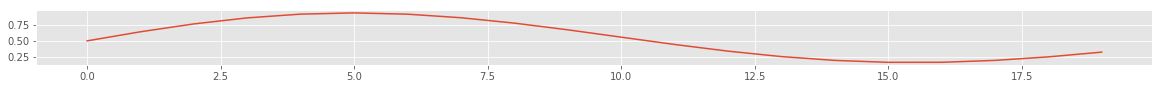

In [8]:
[plot_line(y=x[n, :, 0], figsize=(20, 1)) for n in range(x.shape[0])]

We are building a many-to-one sequence problem - feeding in the sequence and then making a single prediction.  This prediction is for n time steps (where n = output)

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# configure problem
length = 20
test_length = 20

# define model
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(test_length))

opt = Adam(lr=0.001)
model.compile(loss='mae', optimizer=opt)
print(model.summary())

/Users/adam/anaconda3/envs/forecast/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/Users/adam/anaconda3/envs/forecast/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/adam/anaconda3/envs/forecast/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/adam/anaconda3/envs/forecast/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 20)            1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
Total params: 5,460
Trainable params: 5,460
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [10]:
X, y = generate_examples(length, 100000, test_length)
hist = model.fit(X, y, batch_size=10, epochs=1)

Epoch 1/1
100000/100000 [==============================] - 291s 3ms/step - loss: 0.0265


### Predictions

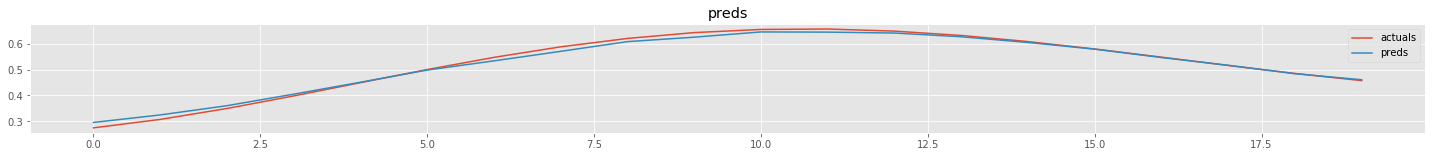

In [16]:
X, y = generate_examples(length, 1, test_length)

preds = model.predict(X)

import pandas as pd
df = pd.DataFrame(index=np.arange(len(y[0])))
df.loc[:, 'actuals'] = y[0]
df.loc[:, 'preds'] = preds[0]

f = plot_time_series(df, list(df.columns), same_plot=True)